# Optimize your hset

IRASA - as an algoritm - is very appealing, because its so simple. In the end we are just up/downsampling signals, computing psd's and averaging them.
This means that we only have a single hyperparameter to set when running a model, the set of up- and downsampling factors. 
Correctly specifying the hset is very important to avoid poorly specified models (see also irasa_pitfalls.ipynb and improving_irasa_models.ipynb).
In both examples we looked at rather simple spectra, where power decreases with the same exponent across the whole spectrum.
Here we consider also spectra that contain a spectral knee and introduce an approach to improve your hset specification. In the presence of spectral knees.

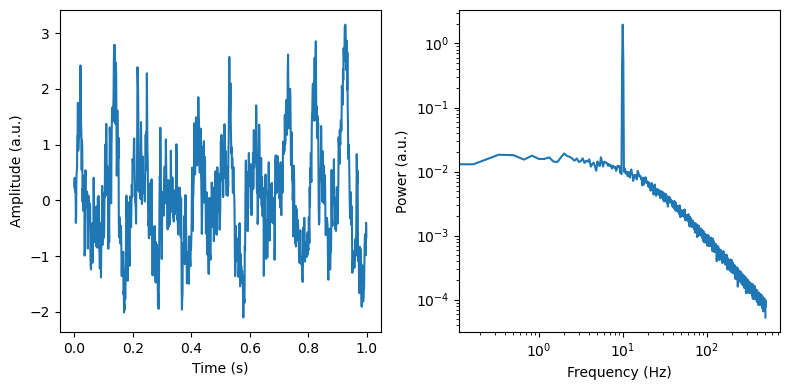

In [8]:
from neurodsp.sim import sim_combined
from neurodsp.utils import create_times
import numpy as np
import scipy.signal as dsp
import matplotlib.pyplot as plt
import pandas as pd
from pyrasa.irasa import irasa
import seaborn as sns

# %% Lets check the knee
fs = 1000
n_seconds = 60
knee_freq = 15
exp = 1.5
knee = knee_freq ** exp
duration=6
overlap=0.5

sim_components = {'sim_knee': {'exponent1' : -.0, 'exponent2': -1*exp, 'knee': knee}, 
                  #'sim_powerlaw': {'exponent' : -1*exp}, 
                  'sim_oscillation': {'freq' : 10}}

sig = sim_combined(n_seconds=n_seconds, fs=fs, components=sim_components)
times = create_times(n_seconds=n_seconds, fs=fs)


max_times = times < 1
f, axes = plt.subplots(ncols=2, figsize=(8, 4))
axes[0].plot(times[max_times], sig[max_times])
axes[0].set_ylabel('Amplitude (a.u.)')
axes[0].set_xlabel('Time (s)')
freq, psd = dsp.welch(sig, fs=fs, nperseg=duration*fs, noverlap=duration*fs*overlap)
axes[1].loglog(freq, psd)
axes[1].set_ylabel('Power (a.u.)')
axes[1].set_xlabel('Frequency (Hz)')

plt.tight_layout()

When things are specified correctly we can rather unproblematically regenerate our simulated aperiodic model parameters.

,Offset,Knee,Exponent_1,Exponent_2,fit_type,Knee Frequency (Hz),tau,ch_name
0,5.224133e-15,62.112356,0.020776,1.499275,knee,14.580652,0.010915,0


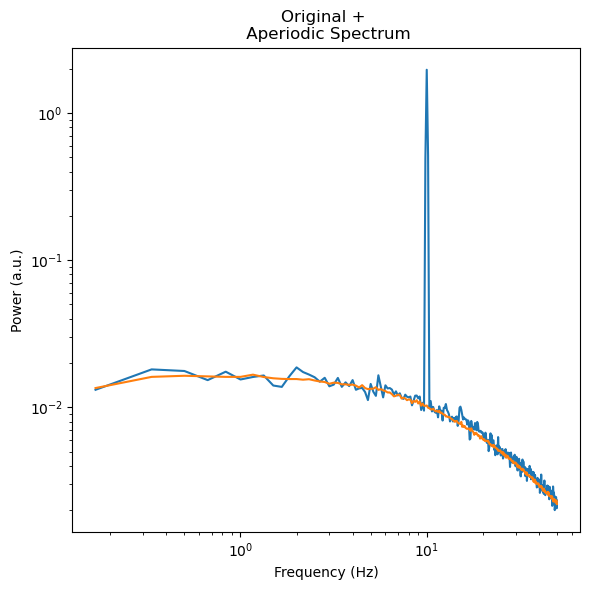

In [9]:
irasa_out = irasa(sig, 
                    fs=fs, 
                    band=(.1, 50), 
                    psd_kwargs={'nperseg': duration*fs, 
                                'noverlap': duration*fs*overlap
                            },
                    hset_info=(1, 2., 0.05))

f, ax = plt.subplots(figsize=(6,6))
ax.loglog(irasa_out.freqs, irasa_out.raw_spectrum[0,:], label='psd')
ax.loglog(irasa_out.freqs, irasa_out.aperiodic[0,:])
ax.set_ylabel('Power (a.u.)')
ax.set_xlabel('Frequency (Hz)')
ax.set_title('Original + \n Aperiodic Spectrum')

f.tight_layout()

irasa_out.fit_aperiodic_model(fit_func='knee').aperiodic_params

In [3]:
irasa_out.fit_aperiodic_model(fit_func='knee').gof

,mse,R2,R2_adj.,BIC,BIC_adj.,AIC,fit_type,ch_name
0,0.000167,0.997508,0.997474,-26.800441,-39.486078,-41.615571,knee,0


However, sometimes we might feel the need to drastically increase our hmax, because we have a very broad oscillation that we want 
to remove from our signal. In this case we start running into problems when trying to recover our simulated Knee Frequency.
This comes from the matter that the exponent before and after the knee get mixed up when up-/downsampling the signal.

,Offset,Knee,Exponent_1,Exponent_2,fit_type,Knee Frequency (Hz),tau,ch_name
0,7.136579e-14,64.059023,0.258964,1.294575,knee,9.925044,0.016036,0


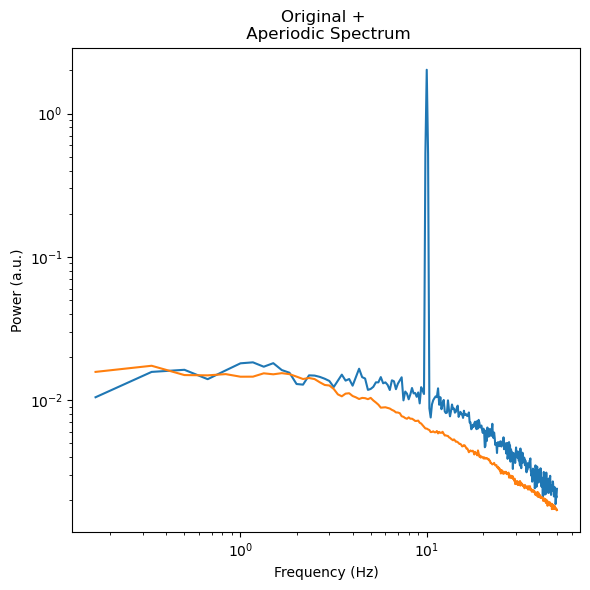

In [4]:
irasa_out_bad = irasa(sig, 
                    fs=fs, 
                    band=(.1, 50), 
                    psd_kwargs={'nperseg': duration*fs, 
                                'noverlap': duration*fs*overlap
                            },
                    hset_info=(1, 8, 0.05))


f, ax = plt.subplots(figsize=(6,6))
ax.loglog(irasa_out_bad.freqs, irasa_out_bad.raw_spectrum[0,:], label='psd')
ax.loglog(irasa_out_bad.freqs, irasa_out_bad.aperiodic[0,:])
ax.set_ylabel('Power (a.u.)')
ax.set_xlabel('Frequency (Hz)')
ax.set_title('Original + \n Aperiodic Spectrum')

f.tight_layout()

irasa_out_bad.fit_aperiodic_model(fit_func='knee').aperiodic_params

So how do we set the hset to avoid this issue. Here I am introducing a way to optimize the hset. 
For this we can take the absolute periodic spectrum, which contains apart from the oscillations also in a way the model error, as we get the periodic spectrum by subtracting the "aperiodic spectrum" from the original psd. So we first need to get rid of the putative oscillations to get a good estimate of the model error. We do this by simply zeroeing oscillations or "peaks" in the periodic spectrum.  The residual absolute spectrum is then averaged and the resultant mean squared error can be used reduce the overall error between the original spectrum (blue line) and modeled aperiodic spectrum (orange line).
Below we can see that the good model has a much lower "error" than the bad model.

In [5]:

def get_aperiodic_error(irasa_out, peak_kwargs=None):

    if peak_kwargs is None:
        peak_kwargs = {}
    #get absolute periodic spectrum
    squared_error = np.abs(irasa_out.periodic[0,:])

    #zero-out peaks
    peaks = irasa_out.get_peaks(**peak_kwargs)
    freqs = irasa_out.freqs

    for _, peak in peaks.iterrows():
        cur_upper = peak['cf'] + peak['bw']
        cur_lower = peak['cf'] - peak['bw']

        freq_mask = np.logical_and(freqs < cur_upper, freqs > cur_lower)

        squared_error[freq_mask] = 0

    return squared_error

/var/folders/6x/k2wvgw51691cj5qd77pzcrfw0000gn/T/ipykernel_51047/150655870.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


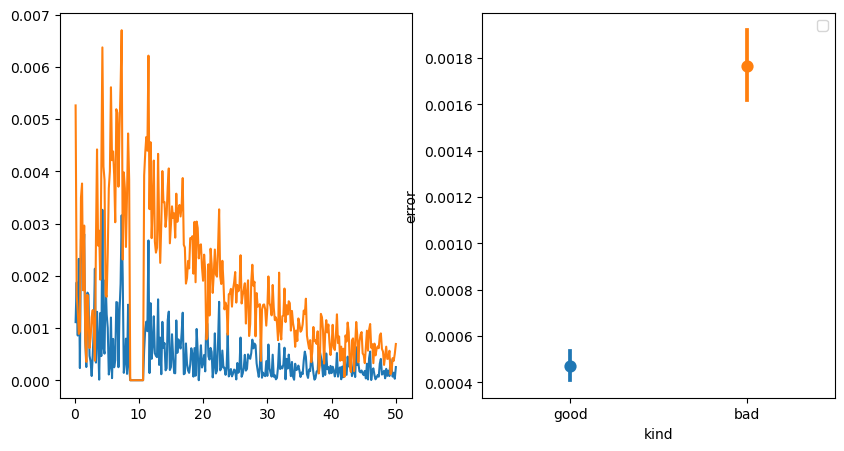

In [6]:
f, ax =plt.subplots(ncols=2, figsize=(10, 5))

ax[0].plot(irasa_out.freqs, get_aperiodic_error(irasa_out), label='good')
ax[0].plot(irasa_out.freqs, get_aperiodic_error(irasa_out_bad), label='bad')


df2plot = pd.DataFrame({'good': get_aperiodic_error(irasa_out),
                        'bad': get_aperiodic_error(irasa_out_bad)}).melt(var_name='kind', value_name='error')

sns.pointplot(df2plot, x='kind', y='error', ax=ax[1], hue='kind')

plt.legend()

However, you don't need to calculate it by hand. The IrasaSpectrum object that gets returned by irasa has a method called `get_aperiodic_error`. 
That is taking your model specifications alongside some information for the peak fitting
to compute the error of your aperiodic spectrum. You just need to specify your kernel size and are good to go :)

In [7]:
from neurodsp.sim import sim_peak_oscillation, sim_powerlaw, sim_knee, sim_oscillation
height = 2
freq = 10
exp = 2.5
fs=1000
n_seconds = 60

peak_params = {'freq': freq, 'bw': 2, 'height': height}
sig_ap = sim_knee(n_seconds=n_seconds, fs=fs, exponent1=-.0, exponent2= -1*exp, knee=knee)
sig = sim_peak_oscillation(sig_ap, fs=fs, **peak_params)

In [83]:
duration=4
overlap=.5

hmax_list = [2, 3, 4, 5, 6, 7, 8, 9,]

irasas = []
for hmax in hmax_list:
    hset_info = (1, hmax, 0.1)
    irasa_out = irasa(sig, 
                        fs=fs, 
                        band=(.1, 50), 
                        psd_kwargs={'nperseg': duration*fs, 
                                    'noverlap': duration*fs*overlap,
                                },
                        hset_info=hset_info)

    irasas.append(irasa_out)

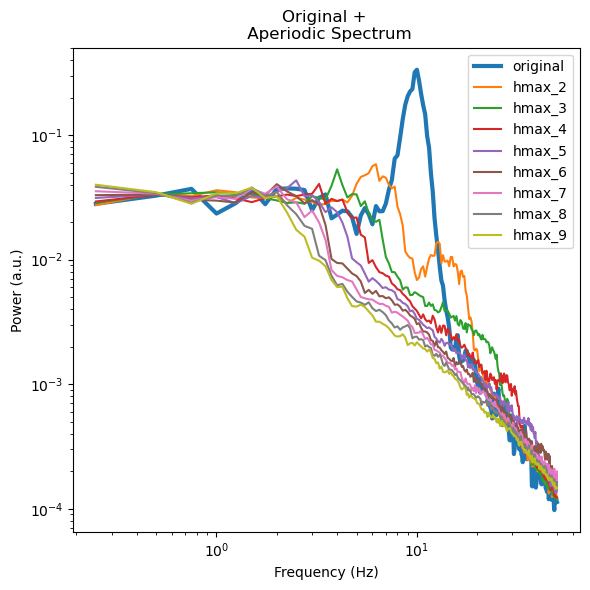

In [84]:
f, ax = plt.subplots(figsize=(6,6))
ax.loglog(irasas[0].freqs, irasas[0].raw_spectrum[0,:], label='original', linewidth=3)
for ix, cur_irasa in zip(hmax_list, irasas):
    ax.loglog(cur_irasa.freqs, cur_irasa.aperiodic[0,:], label=f'hmax_{ix}')

ax.set_ylabel('Power (a.u.)')
ax.set_xlabel('Frequency (Hz)')
ax.set_title('Original + \n Aperiodic Spectrum')
plt.legend()
f.tight_layout()

<Axes: xlabel='hmax', ylabel='error'>

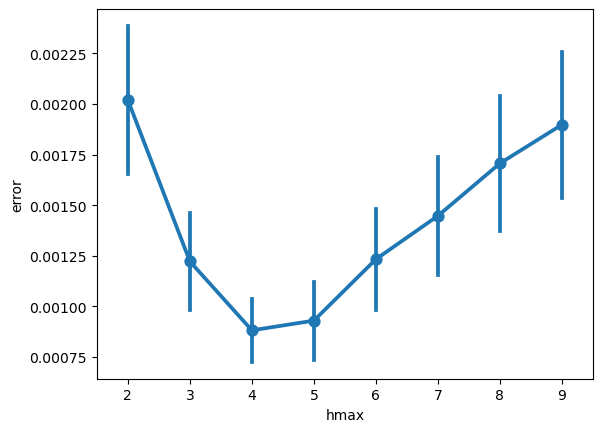

In [85]:
import seaborn as sns

peak_params = {'min_peak_height': 0.1,
               'peak_threshold': 1}

data2plot = pd.DataFrame(dict(zip(hmax_list, [get_aperiodic_error(cur_irasa, peak_params) for cur_irasa in irasas])))

sns.pointplot(data2plot.melt(value_name='error', var_name='hmax'), x='hmax', y='error', errorbar='se')

Visualizing the errors shows the best hmax for our specific dataset as the one with the lowest error